$$\log p(\phi | \{x_i\}) \approx \prod\limits_{i=1}^N \frac{1}{S_i} \sum\limits_{j=1}^{S_i} p(\theta_{ij} | \phi)$$

For normalizing flows 
$$p(\theta_{ij} | \phi) = q_\phi(\theta_{ij})$$

Then a MAP solution for $\phi$ can be obtained by maximizing $\log p(\phi | \{ x_i \})$, which is equivalent to maximizing
$$\sum_{i=1}^N \log \sum\limits_{j=1}^S q_\phi(\theta_{ij})$$


In [1]:
import os
import h5py 
import numpy as np
import fitsio
from tqdm.auto import trange
import astropy.table as aTable
from astropy.cosmology import Planck13

In [2]:
import copy
#from nflows import transforms, distributions, flows
import torch
from torch import nn
from torch import optim
import torch.distributions as D

In [3]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
dat_dir = '/tigress/chhahn/provabgs/svda'

In [5]:
if torch.cuda.is_available(): 
    device = torch.device(type='cuda', index=0)
else: 
    device = 'cpu'

# compile $M_*$ posteriors

In [6]:
bgs = aTable.Table.read(os.path.join(dat_dir, 'BGS_ANY_full.provabgs.hdf5'))

In [7]:
bgs[:5]

TARGETID,RA,DEC,Z_HP,ZERR,TSNR2_BGS,MAG_G,MAG_R,MAG_Z,MAG_W1,FIBMAG_R,HPIX_64,"provabgs_mcmc [100,13]",provabgs_theta_bf [13],provabgs_z_max,provabgs_logMstar_bf,provabgs_logMstar [100],SCHLEGEL_COLOR,provabgs_w_zfail,provabgs_w_fibassign,is_bgs_bright,is_bgs_faint
int64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool
39633390185481181,191.17913199949842,60.25733587654764,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,129.0,False,False
39633390164510024,188.6998080571996,60.21175772175424,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,3.225,False,False
39633390185480955,191.14955067198017,60.34047183206205,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,129.0,False,False
39633390185480938,191.14757099005186,60.345815959235,0.2819459922463374,2.191690764397e-05,1361.7778,20.420939956138607,19.440977833152942,18.807486906915823,18.725561063547207,21.083244145949642,11226,11.091623656909688 .. 0.3684622521221414,11.14249424405227 .. 0.3651476796540595,0.2891440449335749,10.894820213317871,10.848259925842285 .. 10.952618598937988,0.1059712957858181,1.0369954283580962,3.0714285714285716,True,False
39633416324383107,187.05117249536465,62.614542270156655,0.2703579310142208,0.00018002802349298926,1218.0295,20.876585604498494,19.373871860075226,18.567397256862876,18.32574859422363,20.212708263179056,11251,11.127879812361321 .. 0.6691898790548064,11.16028636319183 .. 0.6710591095679554,0.2822033708476234,10.909546852111816,10.877055168151855 .. 10.874772071838379,-0.3616078306686752,1.0018031916676053,1.0,True,False


In [8]:
has_posterior = (bgs['provabgs_z_max'].data != -999.)
is_bgs_bright = bgs['is_bgs_bright']
is_bgs_faint = bgs['is_bgs_faint']

In [9]:
bgs = bgs[has_posterior & is_bgs_bright]
print('%i BGS Bright galaxies with posteriors' % len(bgs))

143017 BGS Bright galaxies with posteriors


# calculate $V_{\rm max}$ with *Planck (2013)* cosmology

In [20]:
f_area = (173.641/(4.*np.pi*(180/np.pi)**2))
bgs['Vmax'] = Planck13.comoving_volume(bgs['provabgs_z_max'].data).value * Planck13.h**3 * f_area # (Mpc/h)^3

(6.0, 13.0)

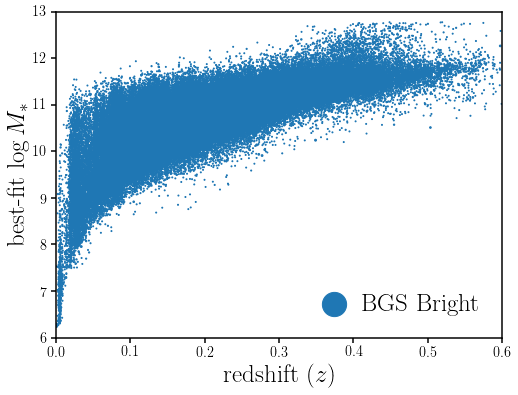

In [12]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.scatter(bgs['Z_HP'].data, bgs['provabgs_logMstar_bf'].data, 
            s=bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign'].data, c='C0', label='BGS Bright')
sub.legend(loc='lower right', fontsize=25, markerscale=10, handletextpad=0.1)
sub.set_xlabel(r"redshift ($z$)", fontsize=25)
sub.set_xlim(0., 0.6)
sub.set_ylabel(r"best-fit $\log M_*$", fontsize=25)
sub.set_ylim(6., 13.)

In [13]:
logM_posteriors = bgs['provabgs_logMstar'].data
vmaxes = bgs['Vmax'].data

(7.0, 12.5)

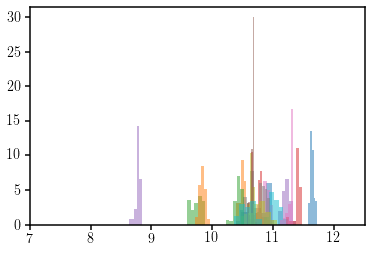

In [14]:
for i in np.random.choice(np.arange(logM_posteriors.shape[0]), size=20, replace=False): 
    plt.hist(logM_posteriors[i,:], bins=5, alpha=0.5, density=True)
plt.xlim(7., 12.5)

# estimate $p(M_* | \{x_i, z_i \})$ in $z$ bins --- incorrectly

Lets just look at the median of the posteriors

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


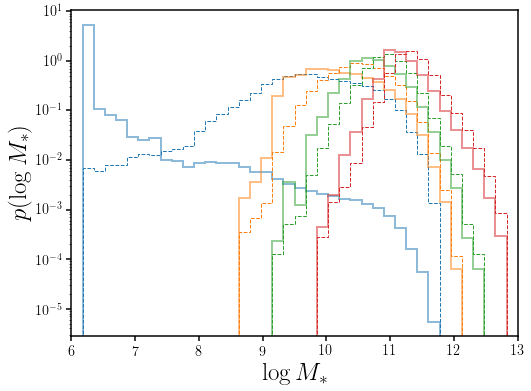

In [21]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
for i, zmin, zmax in zip(range(4), [0., 0.1, 0.2, 0.3], [0.1, 0.2, 0.3, 0.4]):
    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax) & bgs['is_bgs_bright']

    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area # (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (vmaxes.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']
    
    _ = sub.hist(np.median(logM_posteriors[zlim], axis=1), bins=40, range=(6., 13.), color='C%i' % i, 
                 linestyle='--', histtype='step', density=True)
    _ = sub.hist(np.median(logM_posteriors[zlim], axis=1), weights=w_import[zlim], bins=40, range=(6., 13.), 
                 color='C%i' % i, linewidth=2, histtype='step', alpha=0.5, density=True)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(6., 13)
sub.set_ylabel(r'$p(\log M_*)$', fontsize=25)
sub.set_yscale('log')
plt.show()

# estimate $p(M_* | \{x_i, z_i \})$ in $z$ bins --- correctly

In [22]:
# def normflow(ndim, nhidden, nblocks): 
#     blocks = []
#     for iblock in range(nblocks): 
#         blocks += [
#             transforms.MaskedAffineAutoregressiveTransform(
#                 features=ndim, 
#                 hidden_features=nhidden, 
#                 use_residual_blocks=True)#, transforms.RandomPermutation(features=ndim)
#         ]
#     transform = transforms.CompositeTransform(blocks)

#     # Define a base distribution.
#     base_distribution = distributions.StandardNormal(shape=[ndim])

#     # Combine into a flow.
#     return flows.Flow(transform=transform, distribution=base_distribution)


class GaussianMixtureModel(nn.Module):
    def __init__(self, n_components: int=2):
        super().__init__()
        logweights = torch.zeros(n_components, )
        means   = torch.randn(n_components, ) + 10.
        logstdevs  = 0.1 * torch.tensor(np.random.randn(n_components, ))
        self.logweights = torch.nn.Parameter(logweights)
        self.means   = torch.nn.Parameter(means)
        self.logstdevs  = torch.nn.Parameter(logstdevs)
    
    def forward(self, x):
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        return - gmm.log_prob(x).mean()
    
    def log_prob(self, x): 
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        return gmm.log_prob(x)
    
    def sample(self, N):
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        
        return gmm.sample(N)
    
    
def Loss(qphi, post, w): 
    ''' calculate loss
    
    \sum_i^Ng w_i * \log \sum_j^Ns qphi(\theta_ij)
    
    '''
    logqphi = qphi.log_prob(post.flatten()[:,None]).reshape(post.shape)

    return -torch.sum(w * torch.logsumexp(logqphi, axis=1))  

In [23]:
zmins = [0.01 + 0.04 * i for i in range(10)]
zmaxs = [0.01 + 0.04 * (i+1) for i in range(10)]

```python 
best_models_z = [] 
for zmin, zmax in zip(zmins, zmaxs):
    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)

    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 # (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (vmaxes.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']
    
    x_data = torch.tensor(logM_posteriors[zlim].astype(np.float32)).to(device)
    w_data = torch.tensor(w_import[zlim].astype(np.float32)).to(device)
    
    batch_size = 128
    Ntrain = int(0.9 * x_data.shape[0])
    Nvalid = x_data.shape[0] - Ntrain # int(0.1 * x_data.shape[0])

    trainloader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(x_data[:Ntrain], w_data[:Ntrain]),
            batch_size=batch_size,
            shuffle=True)

    validloader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(x_data[Ntrain:], w_data[Ntrain:]),
            batch_size=batch_size)
    
    lr = 1e-3
    num_iter = 1000
    patience = 20

    fig = plt.figure(figsize=(6,4))
    sub = fig.add_subplot(111)
    
    _ = sub.hist(np.median(logM_posteriors[zlim], axis=1), 
             weights=w_import[zlim]*10000./np.sum(w_import[zlim]), 
             range=(7., 13.), bins=40, histtype='step', 
             color='k', linestyle='--', linewidth=2)
    
    best_flows, best_valid_losses, vls = [], [], []
    for i in range(5): 
        ncomp = int(np.random.uniform(5, 100))
        flow = GaussianMixtureModel(n_components=ncomp)
        flow.to(device)
        print('GMM with %i components' % ncomp)

        # parameters = [weights, means, stdevs]
        optimizer = optim.Adam(flow.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lr, total_steps=num_iter)

        best_epoch, best_valid_loss = 0, np.inf
        valid_losses = []

        t = trange(num_iter, leave=False)
        for epoch in t:
            train_loss = 0.
            for batch in trainloader: 
                optimizer.zero_grad()
                _post, _w = batch
                _post = _post.to(device)
                _w = _w.to(device)

                loss = Loss(flow, _post, _w)
                loss.backward()
                train_loss += loss.item()
                optimizer.step()
            train_loss /= len(trainloader.dataset)

            with torch.no_grad():
                valid_loss = 0.
                for batch in validloader: 
                    _post, _w = batch
                    _post = _post.to(device)
                    _w = _w.to(device)

                    loss = Loss(flow, _post, _w)                
                    valid_loss += loss.item()
                valid_loss /= len(validloader.dataset)           
                valid_losses.append(valid_loss)

            scheduler.step()

            t.set_description('Epoch: %i TRAINING Loss: %.2e VALIDATION Loss: %.2e' % 
                              (epoch, train_loss, valid_loss), refresh=False)

            if valid_loss < best_valid_loss: 
                best_valid_loss = valid_loss
                best_epoch = epoch
                best_flow = copy.deepcopy(flow)
            else: 
                if best_epoch < epoch - patience: 
                    print('>>>%i \t %.5e' % (epoch, best_valid_loss))
                    break
            
        with torch.no_grad(): 
            post_prime = best_flow.sample((10000,))
            _ = sub.hist(np.array(post_prime.detach().cpu()), range=(7., 13.), bins=40, histtype='step', linewidth=2)

        best_flows.append(best_flow)
        best_valid_losses.append(best_valid_loss)
        vls.append(valid_losses)
        
    sub.set_xlabel(r'$\log M_*$', fontsize=25)
    sub.set_xlim(7., 13.)
    sub.set_ylabel(r'$p(\log M_*)$', fontsize=25)
    sub.set_yscale('log')
    plt.show()
    
    ibest = np.argmin(best_valid_losses)
    best_models_z.append(best_flows[ibest])

for best_model, zmin, zmax in zip(best_models_z[:8], zmins, zmaxs): 
    torch.save(best_model, os.path.join(dat_dir, 'psmf.gmm.bgs_bright.z%.2f_%.2f.best.pt' % (zmin, zmax)))            
```

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


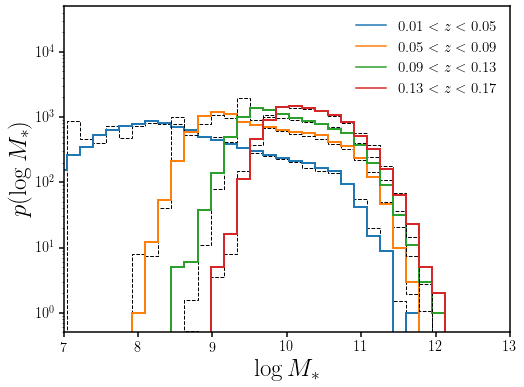

In [24]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
for i, zmin, zmax in zip(range(4), zmins, zmaxs):
    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)

    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area # (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (vmaxes.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']
    
    #psmf_model = best_models_z[i] 
    psmf_model = torch.load(os.path.join(dat_dir, 'psmf.gmm.bgs_bright.z%.2f_%.2f.best.pt' % (zmin, zmax)), map_location=device)
    with torch.no_grad(): 
        post_prime = psmf_model.sample((10000,))
    
    _ = sub.hist(np.median(logM_posteriors[zlim], axis=1), 
                 weights=w_import[zlim]*10000./np.sum(w_import[zlim]), 
                 range=(6., 13.), bins=40, histtype='step', 
                 color='k', linestyle='--', linewidth=1) 
    
    _ = sub.hist(np.array(post_prime.detach().cpu()), range=(6., 13.), bins=40, 
                 color='C%i' % i, histtype='step', linewidth=2)
    sub.plot([], [], c='C%i' % i, label='$%.2f < z < %.2f$' % (zmin, zmax))

sub.legend(loc='upper right', fontsize=15)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(7., 13.)
sub.set_ylabel(r'$p(\log M_*)$', fontsize=25)
sub.set_yscale('log')
sub.set_ylim(5e-1, 5e4)
plt.show()

# normalizing the pSMF

In [25]:
_zmin, _zmax, mlim = np.loadtxt(os.path.join(dat_dir, 'psmf.logmstar_comp_limit.dat'), unpack=True, usecols=[0, 1, 2])

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


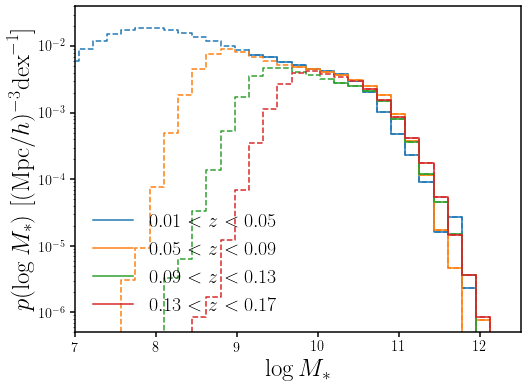

In [46]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
for i, zmin, zmax in zip(range(4), zmins, zmaxs):
    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)

    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area# (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (vmaxes.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']

    # calculate normalization
    norm = np.sum(w_import[zlim]) / (v_zmax - v_zmin)
    #psmf_model = best_models_z[i] 
    psmf_model = torch.load(os.path.join(dat_dir, 'psmf.gmm.bgs_bright.z%.2f_%.2f.best.pt' % (zmin, zmax)), map_location=device)
    with torch.no_grad(): 
        post_prime = psmf_model.sample((100000,))
    
    # calculate normalization    
    #_ = sub.hist(np.median(logM_posteriors[zlim], axis=1), 
    #             weights=w_import[zlim]*norm, #10000./np.sum(w_import[zlim]), 
    #             range=(6., 13.), bins=40, histtype='step', 
    #             color='k', linestyle='--', linewidth=1) 
    h, be = np.histogram(np.array(post_prime.detach().cpu()), 
                 weights=np.repeat(norm, 100000) / 100000, range=(6., 13.), bins=40)
    
    sub.step(be[:-1], h, where='pre', color='C%i' % i, linestyle='--')
    sub.step(be[:-1][be[:-1] > mlim[2*i+1]], h[be[:-1] > mlim[2*i+1]], where='pre', color='C%i' % i, linestyle='-')
    sub.plot([], [], c='C%i' % i, label='$%.2f < z < %.2f$' % (zmin, zmax))
    #sub.axvline(mlim[2*i+1], color='C%i' % i, linestyle=':')
sub.legend(loc='lower left', fontsize=20)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(7., 12.5)
sub.set_ylabel(r'$p(\log M_*)$ [$({\rm Mpc}/h)^{-3}{\rm dex}^{-1}$]', fontsize=25)
sub.set_yscale('log')
sub.set_ylim(5e-7, 4e-2)
plt.show()

# jack knife uncertainties

In [47]:
fields = [
    ((bgs['RA'] > 140) & (bgs['RA'] < 160)), 
    ((bgs['RA'] > 160) & (bgs['RA'] < 185) & (bgs['DEC'] > -10) & (bgs['DEC'] < 10)), 
    ((bgs['RA'] > 205) & (bgs['RA'] < 212) & (bgs['DEC'] > 2) & (bgs['DEC'] < 8)), 
    ((bgs['RA'] > 210) & (bgs['RA'] < 224) & (bgs['DEC'] > -5) & (bgs['DEC'] < 5) & ~((bgs['RA'] > 205) & (bgs['RA'] < 212) & (bgs['DEC'] > 2) & (bgs['DEC'] < 8))),
    ((bgs['RA'] > 190) & (bgs['RA'] < 200) & (bgs['DEC'] > 20) & (bgs['DEC'] < 30)), 
    ((bgs['RA'] > 210) & (bgs['RA'] < 225) & (bgs['DEC'] > 30) & (bgs['DEC'] < 40)),     
    ((bgs['RA'] > 250) & (bgs['RA'] < 260) & (bgs['DEC'] > 30) & (bgs['DEC'] < 40)),
    ((bgs['RA'] > 230) & (bgs['RA'] < 255) & (bgs['DEC'] > 40) & (bgs['DEC'] < 45)),    
    ((bgs['RA'] > 210) & (bgs['RA'] < 225) & (bgs['DEC'] > 45) & (bgs['DEC'] < 58)),        
    ((bgs['RA'] > 235) & (bgs['RA'] < 255) & (bgs['DEC'] > 50) & (bgs['DEC'] < 60)), 
    ((bgs['RA'] > 180) & (bgs['RA'] < 200) & (bgs['DEC'] > 55) & (bgs['DEC'] < 70)), 
    ((bgs['RA'] > 260) & (bgs['RA'] < 280) & (bgs['DEC'] > 55) & (bgs['DEC'] < 70))    
]

A_fields = [164.965, 156.064, 164.917, 138.785, 155.972, 164.848, 165.120, 148.024, 
            165.015, 165.030, 164.890, 156.806]

Text(0, 0.5, 'Dec')

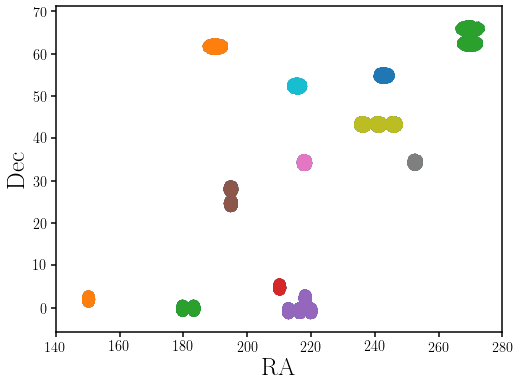

In [48]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.scatter(bgs['RA'], bgs['DEC'], s=1)
for field in fields: 
    sub.scatter(bgs['RA'][field], bgs['DEC'][field], s=1)
sub.set_xlabel('RA', fontsize=25)
sub.set_xlim(140, 280)
sub.set_ylabel('Dec', fontsize=25)
#sub.set_ylim(-10, 10)

In [22]:
lr = 1e-3
num_iter = 1000
patience = 20

for zmin, zmax in zip(zmins, zmaxs):
    for i_jack, field in enumerate(fields): # loop through jackknife fields
        fgmm = os.path.join(dat_dir, 'psmf.gmm.bgs_bright.z%.2f_%.2f.jack%i.best.pt' % (zmin, zmax, i_jack))
        if os.path.isfile(fgmm): continue
        
        # Vmax based importance weights
        zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax) & ~field

        v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 # (Mpc/h)^3
        v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 # (Mpc/h)^3

        w_import = (v_zmax - v_zmin) / (vmaxes.clip(v_zmin, v_zmax) - v_zmin) 
        w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']

        x_data = torch.tensor(logM_posteriors[zlim].astype(np.float32)).to(device)
        w_data = torch.tensor(w_import[zlim].astype(np.float32)).to(device)

        batch_size = 128
        Ntrain = int(0.9 * x_data.shape[0])
        Nvalid = x_data.shape[0] - Ntrain # int(0.1 * x_data.shape[0])

        trainloader = torch.utils.data.DataLoader(
                torch.utils.data.TensorDataset(x_data[:Ntrain], w_data[:Ntrain]),
                batch_size=batch_size,
                shuffle=True)

        validloader = torch.utils.data.DataLoader(
                torch.utils.data.TensorDataset(x_data[Ntrain:], w_data[Ntrain:]),
                batch_size=batch_size)

        best_flows, best_valid_losses = [], []
        for i in range(3): 
            ncomp = int(np.random.uniform(5, 100))
            flow = GaussianMixtureModel(n_components=ncomp)
            flow.to(device)
            print('GMM with %i components' % ncomp)

            # parameters = [weights, means, stdevs]
            optimizer = optim.Adam(flow.parameters(), lr=lr)
            scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lr, total_steps=num_iter)

            best_epoch, best_valid_loss = 0, np.inf
            valid_losses = []

            t = trange(num_iter, leave=False)
            for epoch in t:
                train_loss = 0.
                for batch in trainloader: 
                    optimizer.zero_grad()
                    _post, _w = batch
                    _post = _post.to(device)
                    _w = _w.to(device)

                    loss = Loss(flow, _post, _w)
                    loss.backward()
                    train_loss += loss.item()
                    optimizer.step()
                train_loss /= len(trainloader.dataset)

                with torch.no_grad():
                    valid_loss = 0.
                    for batch in validloader: 
                        _post, _w = batch
                        _post = _post.to(device)
                        _w = _w.to(device)

                        loss = Loss(flow, _post, _w)                
                        valid_loss += loss.item()
                    valid_loss /= len(validloader.dataset)           
                    valid_losses.append(valid_loss)

                scheduler.step()

                t.set_description('Epoch: %i TRAINING Loss: %.2e VALIDATION Loss: %.2e' % 
                                  (epoch, train_loss, valid_loss), refresh=False)

                if valid_loss < best_valid_loss: 
                    best_valid_loss = valid_loss
                    best_epoch = epoch
                    best_flow = copy.deepcopy(flow)
                else: 
                    if best_epoch < epoch - patience: 
                        print('>>>%i \t %.5e' % (epoch, best_valid_loss))
                        break

            best_flows.append(best_flow)
            best_valid_losses.append(best_valid_loss)
            
        ibest = np.argmin(best_valid_losses)
        torch.save(best_flows[ibest], fgmm)

GMM with 10 components


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>257 	 -1.06015e+01
GMM with 72 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>372 	 -1.06241e+01
GMM with 20 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>244 	 -1.06011e+01
GMM with 63 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>254 	 -1.04617e+01
GMM with 50 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>231 	 -1.04598e+01
GMM with 11 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>235 	 -1.04547e+01
GMM with 92 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>219 	 -1.04544e+01
GMM with 53 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>259 	 -1.04570e+01
GMM with 76 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>226 	 -1.04557e+01
GMM with 45 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>234 	 -1.07164e+01
GMM with 74 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>238 	 -1.07129e+01
GMM with 18 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>245 	 -1.07158e+01
GMM with 5 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>226 	 -1.03898e+01
GMM with 11 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>229 	 -1.03905e+01
GMM with 52 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>224 	 -1.03910e+01
GMM with 46 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>227 	 -1.05903e+01
GMM with 79 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>248 	 -1.05937e+01
GMM with 24 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>273 	 -1.05906e+01
GMM with 81 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>187 	 -8.93754e+00
GMM with 83 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>201 	 -8.93896e+00
GMM with 57 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>195 	 -8.93843e+00
GMM with 7 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>234 	 -1.05528e+01
GMM with 67 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>281 	 -1.05654e+01
GMM with 89 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>238 	 -1.05584e+01
GMM with 45 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>295 	 -8.15918e+00
GMM with 89 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>353 	 -8.16162e+00
GMM with 96 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>348 	 -8.16146e+00
GMM with 61 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>414 	 -8.49792e+00
GMM with 93 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>373 	 -8.49598e+00
GMM with 16 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>341 	 -8.49689e+00
GMM with 38 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>366 	 -8.20959e+00
GMM with 57 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>387 	 -8.20979e+00
GMM with 14 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>416 	 -8.20957e+00
GMM with 38 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>362 	 -8.34552e+00
GMM with 77 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>440 	 -8.34865e+00
GMM with 27 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>341 	 -8.34533e+00
GMM with 40 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>353 	 -8.20198e+00
GMM with 98 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>360 	 -8.20166e+00
GMM with 37 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>329 	 -8.20006e+00
GMM with 10 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>308 	 -8.10852e+00
GMM with 22 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>379 	 -8.11256e+00
GMM with 40 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>326 	 -8.11237e+00
GMM with 11 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>517 	 -8.13251e+00
GMM with 50 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>430 	 -8.13313e+00
GMM with 46 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>352 	 -8.13143e+00
GMM with 57 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>354 	 -8.20543e+00
GMM with 65 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>318 	 -8.20498e+00
GMM with 69 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>340 	 -8.20432e+00
GMM with 36 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>356 	 -8.08991e+00
GMM with 89 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>452 	 -8.09482e+00
GMM with 15 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>282 	 -8.08747e+00
GMM with 28 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>350 	 -8.15432e+00
GMM with 31 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>308 	 -8.15379e+00
GMM with 46 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>412 	 -8.15743e+00
GMM with 29 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>253 	 -6.75020e+00
GMM with 76 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>252 	 -6.75075e+00
GMM with 22 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>338 	 -6.75085e+00
GMM with 26 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>529 	 -8.19961e+00
GMM with 49 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>510 	 -8.19911e+00
GMM with 72 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>467 	 -8.19773e+00
GMM with 46 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>400 	 -7.98907e+00
GMM with 32 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>402 	 -7.98825e+00
GMM with 68 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>427 	 -7.99083e+00
GMM with 16 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>403 	 -8.90810e+00
GMM with 46 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>434 	 -8.91073e+00
GMM with 73 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>398 	 -8.90709e+00
GMM with 69 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>411 	 -7.99868e+00
GMM with 32 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>432 	 -7.99659e+00
GMM with 28 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>372 	 -8.00070e+00
GMM with 9 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>403 	 -8.43737e+00
GMM with 35 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>429 	 -8.43227e+00
GMM with 78 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>456 	 -8.43902e+00
GMM with 69 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>422 	 -8.11556e+00
GMM with 24 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>396 	 -8.11811e+00
GMM with 22 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>367 	 -8.11184e+00
GMM with 68 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>397 	 -8.01441e+00
GMM with 49 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>388 	 -8.01549e+00
GMM with 56 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>405 	 -8.02002e+00
GMM with 81 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>352 	 -7.86735e+00
GMM with 81 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>396 	 -7.88445e+00
GMM with 42 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>365 	 -7.87067e+00
GMM with 42 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>313 	 -8.30609e+00
GMM with 99 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>329 	 -8.32095e+00
GMM with 79 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>336 	 -8.33213e+00
GMM with 85 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>418 	 -7.96472e+00
GMM with 7 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>407 	 -7.96657e+00
GMM with 17 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>396 	 -7.96553e+00
GMM with 57 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>417 	 -8.00430e+00
GMM with 45 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>432 	 -8.00717e+00
GMM with 31 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>390 	 -8.00863e+00
GMM with 24 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>418 	 -8.75348e+00
GMM with 48 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>413 	 -8.75631e+00
GMM with 44 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>408 	 -8.75420e+00
GMM with 99 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>420 	 -8.19579e+00
GMM with 82 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>397 	 -8.19260e+00
GMM with 82 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>411 	 -8.19613e+00


In [83]:
m13_logms = np.linspace(9., 12., 31) + np.log10((Planck13.h / 0.7)**2)
m13_logsmf = np.array([-1.899, -1.923, -1.970, -2.031, -2.055, -2.106, -2.144, -2.179, -2.188, -2.216, -2.234, -2.236, -2.262, -2.252, -2.285, -2.317, -2.365, -2.419, -2.504, -2.607, -2.728, -2.888, -3.104, -3.332, -3.606, -3.953, -4.363, -4.778, -5.255, -5.87, -6.49])
m13_logsmf_sig = np.array([0.052, 0.048, 0.059, 0.052, 0.050, 0.053, 0.046, 0.051, 0.046, 0.048, 0.047, 0.045, 0.046, 0.049, 0.045, 0.046, 0.049, 0.049, 0.047, 0.046, 0.046, 0.043, 0.041, 0.042, 0.042, 0.047, 0.050, 0.057, 0.066, 0.1, 0.2])

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


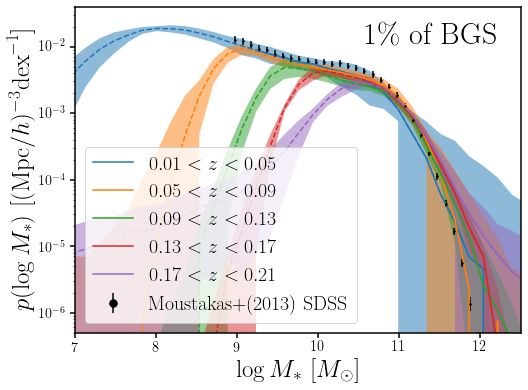

In [89]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
for i, zmin, zmax in zip(range(5), zmins, zmaxs):    
    # calculate normalization
    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax)

    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area# (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (vmaxes.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']

    # calculate normalization
    norm = np.sum(w_import[zlim]) / (v_zmax - v_zmin)
    psmf_model = torch.load(os.path.join(dat_dir, 'psmf.gmm.bgs_bright.z%.2f_%.2f.best.pt' % (zmin, zmax)), 
                            map_location=device)
    with torch.no_grad(): 
        post_prime = psmf_model.sample((100000,))

    h, be = np.histogram(np.array(post_prime.detach().cpu()), 
                 weights=np.repeat(norm, 100000) / 100000, range=(6., 13.), bins=40)
    
    h_jack = []
    for i_jack, field, A_field in zip(range(len(fields)), fields, A_fields): 
        # calculate normalization
        zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax) & ~field
        norm = np.sum(w_import[zlim]) / ((v_zmax - v_zmin) / f_area * (A_field/(4.*np.pi*(180/np.pi)**2)))

        fgmm = os.path.join(dat_dir, 'psmf.gmm.bgs_bright.z%.2f_%.2f.jack%i.best.pt' % (zmin, zmax, i_jack))
        psmf_model = torch.load(fgmm, map_location=device)
        with torch.no_grad(): 
            post_prime = psmf_model.sample((100000,))
        _h, _ = np.histogram(np.array(post_prime.detach().cpu()), 
                             weights=np.repeat(norm, 100000) / 100000, range=(6., 13.), bins=40)
        h_jack.append(_h)
    h_jack = np.array(h_jack)
    
    #sub.plot(0.5*(be[:-1] + be[1:]), h, c='C%i' % i)
    #for h_j in h_jack:
    #    sub.plot(0.5*(be[:-1] + be[1:]), h_j, c='C%i' % i, ls='--')
    sig_jack = np.sqrt(float(len(fields)-1)/float(len(fields)) * np.sum((h_jack - np.mean(h_jack, axis=0))**2, axis=0))
        #_ = sub.hist(np.array(post_prime.detach().cpu()), range=(6., 13.), bins=40, 
        #             color='C%i' % i, histtype='step', linewidth=1)
    #sub.errorbar(0.5*(be[:-1] + be[1:]), h, yerr=sig_jack, c='C%i' % i)
    sub.plot(0.5*(be[:-1] + be[1:]), h, color='C%i' % i, ls='--')
    sub.plot(0.5*(be[:-1] + be[1:])[be[:-1] > mlim[2*i+1]], h[be[:-1] > mlim[2*i+1]], c='C%i' % i, ls='-')
    sub.fill_between(0.5*(be[:-1] + be[1:]), h-sig_jack, h+sig_jack, color='C%i' % i, edgecolor='none', alpha=0.5)
    sub.plot([], [], c='C%i' % i, label='$%.2f < z < %.2f$' % (zmin, zmax))
    
    #sub.step(be[:-1], h, where='pre', color='C%i' % i, linestyle='--')
    #sub.step(be[:-1][be[:-1] > mlim[2*i+1]], h[be[:-1] > mlim[2*i+1]], where='pre', color='C%i' % i, linestyle='-')
sub.errorbar(m13_logms, 10**m13_logsmf, 
             yerr=[10**m13_logsmf - 10**(m13_logsmf - m13_logsmf_sig), 10**(m13_logsmf + m13_logsmf_sig) - 10**m13_logsmf],
             fmt='.k', markersize=3, label='Moustakas+(2013) SDSS')

sub.legend(loc='lower left', fontsize=20, markerscale=5, frameon=True)
sub.set_xlabel(r'$\log M_*$  [$M_\odot$]', fontsize=25)
sub.set_xlim(7., 12.5)
sub.set_ylabel(r'$p(\log M_*)$  [$({\rm Mpc}/h)^{-3}{\rm dex}^{-1}$]', fontsize=25)
sub.set_yscale('log')
sub.set_ylim(5e-7, 4e-2)
sub.text(0.95, 0.95, r'1\% of BGS', ha='right', va='top', fontsize=30, transform=sub.transAxes)
plt.show()